In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import math
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [2]:
# --- Basic Linear Regression Class
class _LinRegBasicModel:
  def __init__(self, Y, X, echo=False):
    if echo:
      print("TASK: Build linear regression model...")
    # --- Type check for X
    if echo:
      print("  1. Validating data.")
    if isinstance(X, np.ndarray):
      if len(X.shape) == 1:
        self.p = 2
      else:
        self.p = X.shape[1] + 1
      self.n = X.shape[0]
      self.X = np.c_[np.repeat(1, self.n).reshape(self.n, 1), X]
      self.var_names = ["Intercept"] + [f"V{i}" for i in range(1, self.p)]
    elif isinstance(X, pd.DataFrame):
      self.p = X.shape[1] + 1
      self.n = X.shape[0]
      self.X = np.c_[np.repeat(1, self.n).reshape(self.n, 1), X.to_numpy()]
      if list(X.columns) == [i for i in range(len(X.columns))]:
        self.var_names = ["Intercept"] + [f"V{i}" for i in range(1, self.p)]
      else:
        self.var_names = ["Intercept"] + list(X.columns)
    elif isinstance(X, pd.Series):
      self.p = 2
      self.n = X.shape[0]
      self.X = np.c_[np.repeat(1, self.n).reshape(self.n, 1), X.to_numpy().reshape((self.n, 1))]
      self.var_names = ["Intercept", "X"]
    else:
      print("Unsupported data matrix (X) type:", type(X))

    # --- Check if Y has the same length as data
    if echo:
      print("  2. Validating response vector.")
    if isinstance(Y, np.ndarray):
      if len(Y.shape) == 1:
        if Y.shape[0] != self.n:
          raise ValueError("Value vector (Y) has different length that data (X).")
        self.Y = Y.reshape(self.n, 1)
      elif len(Y.shape) == 2:
        if Y.shape[0] != self.n:
          raise ValueError("Value vector (Y) has different length that data (X).")
        if Y.shape[1] != 1:
          raise ValueError("Your value vector (Y) has more that one column.")
        self.Y = Y.reshape(self.n, 1)
      else:
        raise ValueError("Your value vector is invalid.")
      self.var_names = ["Y"] + self.var_names
    elif isinstance(Y, pd.DataFrame):
      if Y.shape[0] != self.n:
        raise ValueError("Value vector (Y) has different length that data (X).")
      self.Y = Y.to_numpy()
      if Y.columns[0] == 0:
        self.var_names = ["Y"] + self.var_names
      else:
        self.var_names = [Y.columns[0]] + self.var_names
    elif isinstance(Y, pd.Series):
      if Y.shape[0] != self.n:
        raise ValueError("Value vector (Y) has different length that data (X).")
      self.Y = Y.to_numpy().reshape((self.n, 1))
      self.var_names = ["Y"] + self.var_names

    # Informative form of data
    self.data_matrix = pd.DataFrame(np.c_[self.Y, self.X], columns=self.var_names)

    # SVD decomposition
    if echo:
      print("  3. Decomposing X with using SVD method.")
    self.U, self.D, self.Vt = np.linalg.svd(self.X, full_matrices=False)

    # Calculate estimators
    if echo:
      print("  4. Calculating LSM estimators.")
    self.XX_inv = self.Vt.transpose() @ np.diag(1 / (self.D * self.D)) @ self.Vt
    self.beta = np.squeeze(self.XX_inv @ (self.X.transpose() @ self.Y))

    # Hat matrix and prediction
    if echo:
      print("  5. Calculating hat matrix and Y predictions.")
    self.H = self.U @ self.U.transpose()
    self.Y_pred = self.H @ self.Y

    # Rating the model
    if echo:
      print("  6. Rating the model.")
    self.SST = Y.transpose() @ Y - self.n * Y.mean()
    self.SSE = (Y.transpose() @ Y - Y.transpose() @ self.Y_pred)[0]
    self.SSR = self.SST - self.SSE
    self.R2 = self.SSR / self.SST
    self.R2_adj = 1 - self.SSE * (self.n - 1) / self.SST / (self.n - self.p)

    # Estimators and statistics
    if echo:
      print("  7. Estimating error and calculating statistics.")
    self.S2 = self.SSE / (self.n - self.p)
    self.SE_beta = np.sqrt(self.S2 * np.diag(self.XX_inv))
    self.F_stat = self.SSR * (self.n - self.p) / self.SSE / (self.p - 1)
    self.F_stat_pvalue = 1 - stats.f(self.p - 1, self.n - self.p).cdf(self.F_stat)
    self.t_stat = self.beta / self.SE_beta
    self.t_stat_pvalues = 2 * (1 - stats.t(self.n - self.p).cdf(np.abs(self.t_stat)))

    # Calculating residuals
    if echo:
      print("  8. Calculating residuals.\n")
    self._res = np.squeeze(self.Y - self.Y_pred)
    self._res_stud = self._res / np.sqrt(self.S2 * (1 - np.diag(self.H)))
    self._res_mod = self._res / (1 - np.diag(self.H))
    self._res_mod_stud = self._res_mod / np.sqrt(((self.n - self.p) * (1 - np.diag(self.H)) * self.S2 - self._res ** 2) / (self.n - self.p - 1))
    self.cook_dist = self._res_mod * np.diag(self.H) / self.p / (1 - np.diag(self.H))
    self.residuals = pd.DataFrame({
      "fitValue": self.Y_pred.squeeze(),
      "Residue": self._res,
      "stdResidue": self._res_stud,
      "modResidue": self._res_mod,
      "modStdResidue": self._res_mod_stud,
      "CooksDist": self.cook_dist
    })

  def summary(self):
    max_var_length = max([len(v) for v in self.var_names[1:]])
    # Header
    print(" " * max_var_length + "      Estimate    Std.Error     t.stats     p-value")

    # Estimators
    for i in range(len(self.beta)):
      mark = ""
      if self.t_stat_pvalues[i] <= 0.1:
        mark = '.'
      if self.t_stat_pvalues[i] <= 0.05:
        mark = "*"
      if self.t_stat_pvalues[i] <= 0.001:
        mark = "**"
      if self.t_stat_pvalues[i] <= 0.000001:
        mark = "***"
      print(f"{self.var_names[i + 1]:{max_var_length}}", "  -" if self.beta[i] < 0 else "   ", f"{abs(self.beta[i]):.5e}",
            "  {0:11.4f}".format(self.SE_beta[i]), "  {0:10.4f}".format(self.t_stat[i]), "  {0:10.6f}".format(self.t_stat_pvalues[i]),
            " ", mark, sep="")

    # Info
    print()
    print("(.): p <= 0.1  (*): p <= 0.05  (**): p <= 0.001  (***): p <= 1e-6")
    print()
    print("Variance explanation %:")
    print("  R2: {0:7.7f}".format(self.R2), "     R2 adj.: {0:7.7f}".format(self.R2_adj))
    print()
    print("F-statistics result. H0: all predictors are equal to zero.")
    print("  F: {0:10.4f}".format(self.F_stat), "with p-value: {0:6.6f}".format(self.F_stat_pvalue), f"on ({self.p - 1}, {self.n - self.p}) degree of freedom.")
    print()
    print("Error estimator: {0:10.4f}".format(self.S2))

    if len(np.diag(self.H) >= 2 * self.p / self.n) > 0:
      print()
      print("There are some influential observations. Average influence:", 2 * self.p / self.n)
      print(pd.concat([self.data_matrix.loc[np.diag(self.H) >= 2 * self.p / self.n, self.data_matrix.columns != "Intercept"].reset_index(),
                       pd.DataFrame({"h_ii": np.diag(self.H)[np.diag(self.H) >= 2 * self.p / self.n]})], axis=1))

    if len(abs(self._res_mod_stud) > 2):
      print()
      print("There might be a few protruding observations.")
      print(pd.concat([self.data_matrix.loc[abs(self._res_mod_stud) > 2, self.data_matrix.columns != "Intercept"],
                       self.residuals.loc[abs(self._res_mod_stud) > 2, "modStdResidue"]], axis=1).reset_index())
      print("Consider removing some of them to obtain better model.")

  def print_data_matrix(self):
    print(self.data_matrix)

In [3]:
signals = pd.read_csv("data/train/wind-farm-1-signals-training.csv", sep=";")
signals = signals[["Turbine_ID", "Timestamp", "Grd_Prod_Pwr_Avg", "Amb_WindSpeed_Avg", "Amb_Temp_Avg", "Nac_Temp_Avg", "Rtr_RPM_Avg", "Gear_Bear_Temp_Avg", "Gen_RPM_Avg", "Gen_Bear2_Temp_Avg", "Gen_Bear_Temp_Avg"]]
signals["Timestamp_Datetime"] = pd.to_datetime(signals.Timestamp)
signals.Timestamp_Datetime = signals.Timestamp_Datetime.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second))
signals_T01 = signals.loc[signals.Turbine_ID == "T01"]
signals_T06 = signals.loc[signals.Turbine_ID == "T06"]
signals_T07 = signals.loc[signals.Turbine_ID == "T07"]
signals_T09 = signals.loc[signals.Turbine_ID == "T09"]
signals_T11 = signals.loc[signals.Turbine_ID == "T11"]

In [4]:
def slice_signals(signals_source, turbine_id, wind_bins = np.arange(4, 10.5, 0.5), temp_bins = [4, 15, 19, 24, 41]):
    indices = signals_source.loc[signals_source.Turbine_ID == turbine_id, :].index
    wind = pd.cut(signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Amb_WindSpeed_Avg, bins = np.arange(4, 10.5, 0.5))
    temp = pd.cut(signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Amb_Temp_Avg, bins = temp_bins)
    segments = pd.DataFrame({
        "Wind": wind, 
        "Temp": temp, 
        "Power": signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Grd_Prod_Pwr_Avg, 
        "Time": signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Timestamp_Datetime
    })
    return segments.dropna().loc[segments.Power >= 10, :].sort_values(by = ["Wind", "Temp", "Time"])

In [42]:
batch_size = 30
for i, (name, group) in enumerate(slice_signals(signals, "T01", temp_bins=[4, 15, 20, 25, 30, 41]).groupby(by = ["Temp", "Wind"])):
    temp = group.reset_index()
    group_id = np.repeat(np.arange(0, temp.shape[0] // batch_size + 1, 1, dtype=int), batch_size)
    temp["index"] = group_id[:temp.shape[0]]
    temp["Avg_Power"] = temp.groupby(by="index")["Power"].transform("mean")
    model = _LinRegBasicModel(temp.Avg_Power, np.arange(0, temp.shape[0], 1, dtype=int))  
    

0.9885539157951956
0.9949698546946255
0.9979779952384993
0.9981312627383611
0.99898267387308
0.9991667927517817
0.9994154070557861
0.9995722168856543
0.9997362650814117
0.9997776522952231
0.9997820990659154
0.9999308057094646
0.9877881718484214
0.9938720674011802
0.9973225224819763
0.9974109465022903
0.9988290417076925
0.9984488159810373
0.9986590199563675
0.9990270185838466
0.9994643274102356
0.9994474110255112
0.9995848696637116
0.9996315410116291
0.9861758695651761
0.9945109121603165
0.9972102388122821
0.9982968614351413
0.9988711108456603
0.9982271970609274
0.9989124833149688
0.9991457816806154
0.9988485272500913
0.9994626417305736
0.9994225187142965
0.9995596459128167
0.9922143013036122
0.9973138754979234
0.9988478959835991
0.9989356921841953
0.9990852575931005
0.9988102703259594
0.998970975332732
0.9994445734311038
0.9992981413924521
0.9991472122626416
0.9993307688221745
0.9997974933843928
0.9978025529744886
0.9988278946823199
0.9990011753713423
0.9996552731458486
0.9994604678666

0.009688513119224695
0.011537107945267966
0.009231550211786343
0.014069855935798792
0.005205287303210238
0.0017120497501048604
0.01880213695216071
0.03815182580401455
0.047256243142939525
-0.028745788806684658
0.01832908893324614
0.07677933745086563
-0.002801507546948634
-0.0036396767392682383
-0.006166866997528886
-0.003091103524105465
-0.012319820359027123
-0.006128324387928874
-0.012512960666643203
-0.020063594083445047
-0.028050251947442817
-0.024899169389498432
-0.013134074229188997
0.014025497666391828
-0.013321291396184987
-0.00434416720559383
-0.005489710594948516
-0.012973191809206863
-0.028513146680249513
-0.02845500295578285
-0.05211143428748777
-0.01669143148725105
-0.027028309702627595
-0.029123947169072295
0.008638961597213779
-0.031022875388252658
-0.010968524339746821
-0.01630066403415409
-0.011463661500485944
-0.01275070699886438
-0.019526229984776045
-0.022750969296435386
-0.024573105222159164
-0.07157230637390022
-0.10659117635901261
-0.10174750176343039
-0.078394653

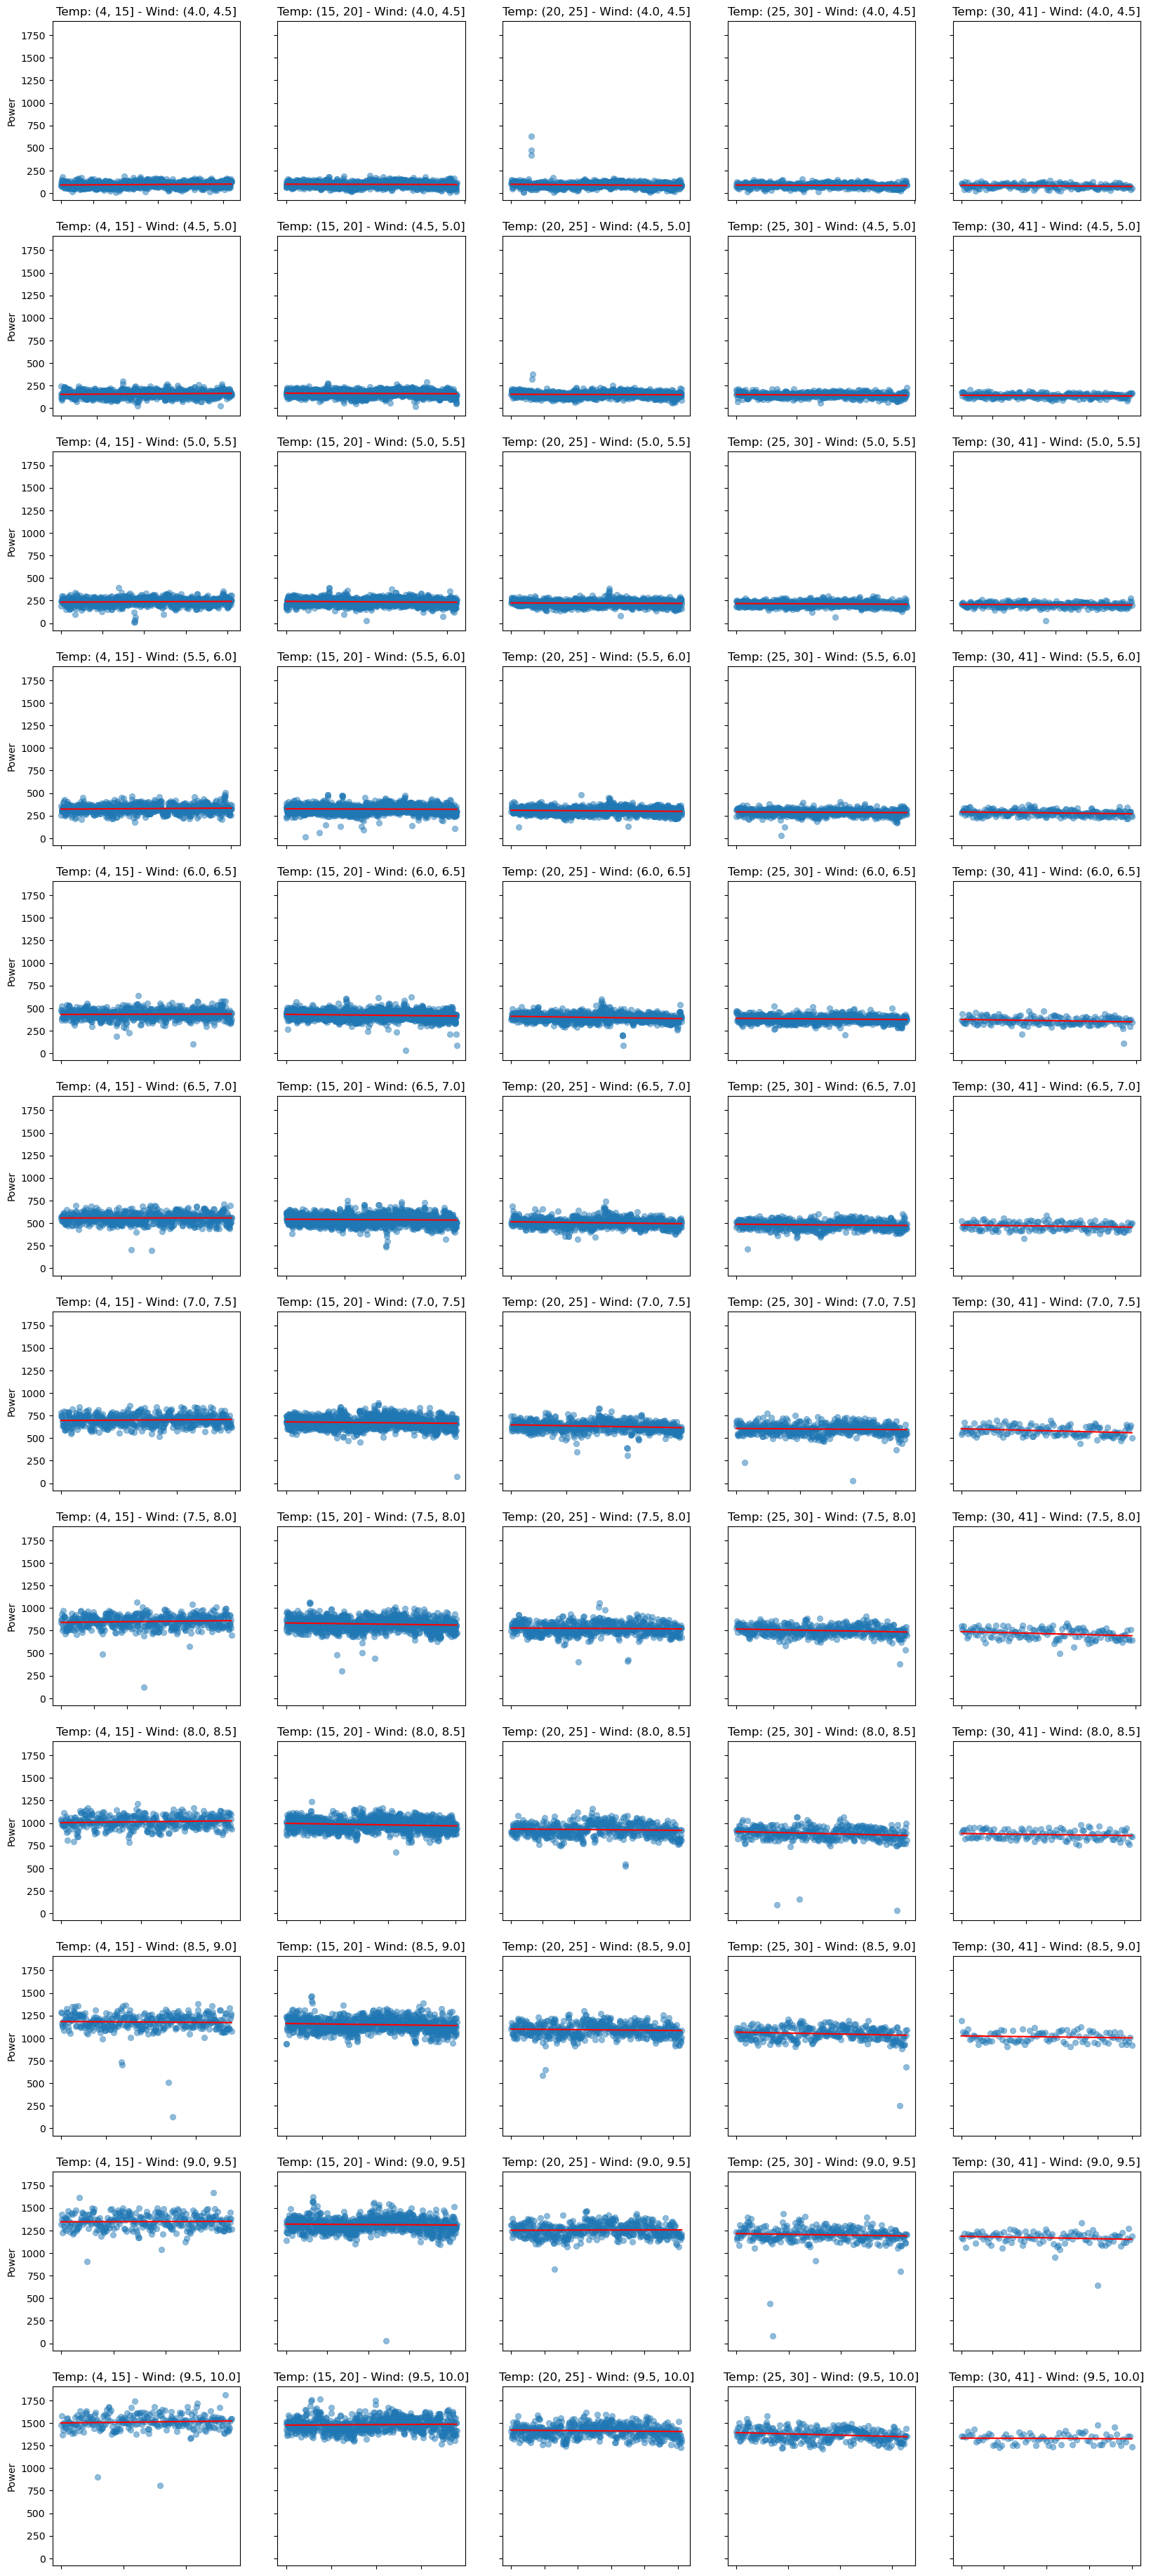

In [50]:
fig, axes = plt.subplots(12, 5, sharey = True, figsize = (20, 48))
batch_size = 30
for i, (name, group) in enumerate(slice_signals(signals, "T01", temp_bins=[4, 15, 20, 25, 30, 41]).groupby(by = ["Temp", "Wind"])):    
    # KMeans
    temp = group.reset_index()
    group_id = np.repeat(np.arange(0, temp.shape[0] // batch_size + 1, 1, dtype=int), batch_size)
    temp["index"] = group_id[:temp.shape[0]]
    temp["Avg_Power"] = temp.groupby(by="index")["Power"].transform("mean")
    model = _LinRegBasicModel(temp.Avg_Power, np.arange(0, temp.shape[0], 1, dtype=int))
    snsplot = sns.scatterplot(ax = axes[i % 12, i // 12], 
                              x = np.arange(0, temp.shape[0], 1, dtype=int), 
                              y = temp.Power, edgecolor = None, alpha = 0.5)
    snsplot.set(xticklabels=[])
    axes[i % 12, i // 12].plot(
        np.arange(0, temp.shape[0], 1, dtype=int), 
        model.beta[0] + model.beta[1] * np.arange(0, temp.shape[0], 1, dtype=int), color="r")
    print(model.beta[1])
    
    
    left_temp, right_temp = name[0].left, name[0].right
    left_wind, right_wind = name[1].left, name[1].right
    axes[i % 12, i // 12].set_title(f"Temp: ({left_temp}, {right_temp}] - Wind: ({left_wind}, {right_wind}]", fontsize=12)

In [121]:
for i, (name, group) in enumerate(slice_signals(signals, "T09").groupby(by = ["Temp", "Wind"])):
    

1046      10:50:00
4028      14:10:00
4072      15:40:00
4175      19:10:00
4233      21:00:00
            ...   
325664    22:20:00
325670    22:30:00
325675    22:40:00
346025    05:10:00
346029    05:20:00
Name: Time, Length: 1038, dtype: object
3525      21:30:00
3531      21:40:00
3539      21:50:00
3620      00:40:00
4014      13:40:00
            ...   
326566    04:20:00
326581    04:50:00
345363    07:10:00
345494    11:30:00
346044    05:50:00
Name: Time, Length: 851, dtype: object
1043      10:40:00
1077      11:50:00
3138      08:30:00
3591      23:40:00
3616      00:30:00
            ...   
325646    21:40:00
345446    09:50:00
345491    11:20:00
346035    05:30:00
346038    05:40:00
Name: Time, Length: 782, dtype: object
921       06:40:00
3141      08:40:00
3588      23:30:00
3599      23:50:00
3609      00:10:00
            ...   
345122    23:00:00
345195    01:30:00
345294    04:50:00
345368    07:20:00
345479    11:00:00
Name: Time, Length: 800, dtype: object
3133   

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7,
       7, 7, 8, 8, 8, 9, 9, 9])